<a href="https://colab.research.google.com/github/jimtete/pneumonia-detection-nov21/blob/main/Notebooks/ResNet_50_DetNET_TypeR_50_STi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Within this notebook we are going to start a different approach at training the model.

In [ ]:
#Connects notebook with google drive.
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Machine\ Learning\ 2021

Mounted at /content/gdrive
/content/gdrive/MyDrive/Machine Learning 2021


###Importing the libraries

In [ ]:
import gc
import numpy as np
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import cv2
import pandas as pd
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import sys

np.set_printoptions(threshold=sys.maxsize)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline



In [ ]:
'''Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.'''
def ResizeImage(x,y):

  golden_ratio = 0.90

  position_ratio = (1-golden_ratio)/2
  size_ratio = golden_ratio+position_ratio

  new_x = ((int)(x*position_ratio))
  new_y = ((int)(y*position_ratio))
  new_width = ((int)(x*size_ratio))
  new_height = ((int)(y*size_ratio))

  return new_x,new_y,new_width,new_height




def noisyGauss(image):
  row,col,ch= image.shape
  mean = 0
  var = 0.1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def noisySnP(image):
  row,col,ch = image.shape
  s_vs_p = 0.5
  amount = 0.04
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
  out[coords] = 255

  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
  out[coords] = 0
  return out

def noisyPoisson(image):
  vals = len(np.unique(image))
  vals = 2 ** np.ceil(np.log2(vals))
  noisy = np.random.poisson(image * vals) / float(vals)
  return noisy

def noisySpeckle(image):
  row,col,ch = image.shape
  gauss = np.random.randn(row,col,ch)
  gauss = gauss.reshape(row,col,ch)        
  noisy = image + image * gauss/6
  return noisy

def change_contrast(img, level):
  factor = (259 * (level + 255)) / (255 * (259 - level))
  def contrast(c):
    return 128 + factor * (c-128)
  return img.point(contrast)


def return_image(img):
  return cv2.imread(img)
  


In [ ]:
train_path = "train_images/train_images"
test_path = "test_images/test_images"


In [ ]:
size = 224,224

#**Temp, pls close**

/content/gdrive/My Drive/Machine Learning 2021/train_images/train_images


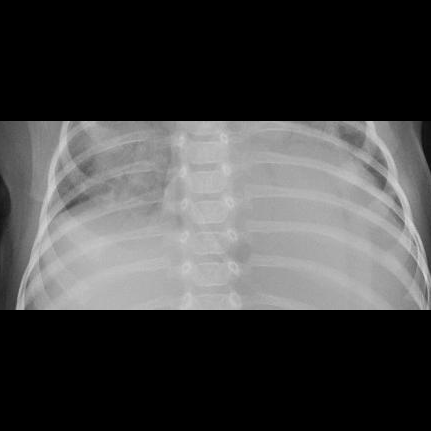

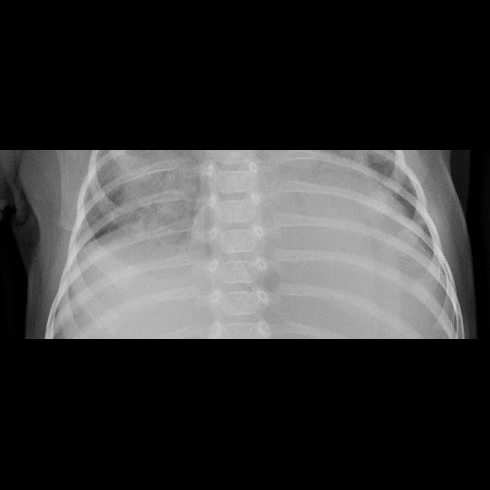

In [ ]:
%cd /content/gdrive/My Drive/Machine Learning 2021/train_images/train_images
img = Image.open("img_6565902374949709512.jpg")
##Adding padding to the x-ray
width, height = img.size
top,left = 0,0

if width>height:
  newHeight,newWidth = width,width
  top = (int)((width-height)/2)
else:
  newHeight,newWidth = height,height
  left = (int)((height-width)/2)

result = Image.new(img.mode, (newWidth, newHeight))
result.paste(img,(left,top))

width, height = result.size
resolution = ResizeImage(width,height)

temp = result

img = result.crop(resolution)

display(img)
display(temp)

#**Resizing pictures**

In [ ]:
%cd /content/gdrive/My Drive/Machine Learning 2021/test_images/test_images

imageNamesList = []

k = 0;
for file_name in glob.glob("*.jpg"):
  img = Image.open(file_name)

  ##Adding padding to the x-ray
  width, height = img.size
  top,left = 0,0

  if width>height:
    newHeight,newWidth = width,width
    top = (int)((width-height)/2)
  else:
    newHeight,newWidth = height,height
    left = (int)((height-width)/2)

  result = Image.new(img.mode, (newWidth, newHeight))
  result.paste(img,(left,top))

  width, height = result.size
  resolution = ResizeImage(width,height)

  img = result.crop(resolution)
  img = img.resize(size)

  img.save("../../Data/test_images/"+file_name)

  k = k+1;

  if(k % 50 ==0):
    print("Finished no {} out of 1168".format(k))
  


%cd ../..

/content/gdrive/My Drive/Machine Learning 2021/test_images/test_images
Finished no 50 out of 1168
Finished no 100 out of 1168
Finished no 150 out of 1168
Finished no 200 out of 1168
Finished no 250 out of 1168
Finished no 300 out of 1168
Finished no 350 out of 1168
Finished no 400 out of 1168
Finished no 450 out of 1168
Finished no 500 out of 1168
Finished no 550 out of 1168
Finished no 600 out of 1168
Finished no 650 out of 1168
Finished no 700 out of 1168
Finished no 750 out of 1168
Finished no 800 out of 1168
Finished no 850 out of 1168
Finished no 900 out of 1168
Finished no 950 out of 1168
Finished no 1000 out of 1168
Finished no 1050 out of 1168
Finished no 1100 out of 1168
Finished no 1150 out of 1168
/content/gdrive/My Drive/Machine Learning 2021


#**The below code creates a new csv file for each set, validation and training**

In [ ]:
def returnLabel(file_name,data,labels):
  k=0;
  for i in data:
    if file_name == i:
      return labels[k]
    k = k + 1

'''
Use the image_set variable in order to choose which set you want to create a new
labels.csv file for.

image_set = "val_images" for validation images
image_set = "train_images" for training images
'''

image_set = "val_images" #"train_images"

if image_set=="val_images":
  csv_name = "val_labels.csv"
else:
  csv_name = "train_labels.csv"


%cd /content/gdrive/My Drive/Machine Learning 2021/Data/cropped_95_percento

imageNameList = []
%cd $image_set
for file_name in glob.glob("*.jpg"):
  imageNameList.append(file_name)

%cd /content/gdrive/My Drive/Machine Learning 2021/Data
data = pd.read_csv("labels.csv")['file_name']
labels = pd.read_csv("labels.csv")['class_id']

val_labels = []

for img in imageNameList:
  label = returnLabel(img,data,labels)
  val_labels.append([img,label])

export_val_labels = pd.DataFrame(val_labels)
export_val_labels.columns = ['file_name','class_id']
export_val_labels.to_csv(csv_name)





/content/gdrive/My Drive/Machine Learning 2021/Data/cropped_95_percento
/content/gdrive/My Drive/Machine Learning 2021/Data/cropped_95_percento/val_images
/content/gdrive/My Drive/Machine Learning 2021/Data


#**Importing the data**

##**For training set**

In [ ]:
%cd /content/gdrive/My Drive/Machine Learning 2021/Data

data = pd.read_csv("labels.csv")['file_name']
y_train = (pd.read_csv("labels.csv")['class_id']).to_numpy()

%cd /content/gdrive/My Drive/Machine Learning 2021/Data/train_images_95

x_train = np.zeros((4672,224,224,3))

for i in range(len(data)):
  x_train[i] = return_image(data[i])
  print("%.2f" % round(((i/4672)*100), 2),"% done...")

gc.collect()
print(x_train.shape)

##**For validation data**

In [ ]:
%cd /content/gdrive/My Drive/Machine Learning 2021/Data

data = pd.read_csv("val_labels.csv")['file_name']
y_val = (pd.read_csv("val_labels.csv")['class_id']).to_numpy()

%cd /content/gdrive/My Drive/Machine Learning 2021/Data/cropped_95_percento/val_images

x_val = np.zeros((672,224,224,3))

i = 0
for file_name in data:
  temp = Image.open(file_name).convert("RGB")
  x_val[i] = np.array(temp)

  i+=1
  print("%.2f" % round(((i/672)*100), 2),"% done...")

gc.collect()
print(x_val.shape)




##**For test images**

In [ ]:
%cd ../test_images

test_image_name_list = []
x_test = np.zeros(((1168,224,224,3)))
i = 0
for file_name in glob.glob("*.jpg"):
  test_image_name_list.append(file_name)
  x_test[i] = return_image(file_name)
  print("%.2f" % round(((i/1168)*100), 2),"% done...")
  i+=1

print(x_test.shape)

#**Importing training data from csv files**

In [ ]:
%cd /content/gdrive/My Drive/Machine Learning 2021/Data/train_val_test
x_train = (pd.read_csv("x_train.csv").to_numpy()).reshape((8000,224,224,3))
x_val = (pd.read_csv("x_val.csv").to_numpy()).reshape((672,224,224,3))
x_test = (pd.read_csv("x_test.csv").to_numpy()).reshape((1168,224,224,3))


%cd ..

y_train = np.zeros((8000))

y_train[0:4000] = (pd.read_csv("train_labels.csv")['class_id']).to_numpy()
y_train[4000:8000] = y_train[0:4000]
y_val = (pd.read_csv("val_labels.csv")['class_id']).to_numpy()

/content/gdrive/My Drive/Machine Learning 2021/Data/train_val_test


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-a79a0ed20644>", line 2, in <module>
    x_train = (pd.read_csv("x_train.csv").to_numpy()).reshape((8000,224,224,3))
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 688, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 460, in _read
    data = parser.read(nrows)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 1198, in read
    ret = self._engine.read(nrows)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 2157, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 847, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx", line 862, in pandas._libs.parsers.TextRead

KeyboardInterrupt: ignored

#**Data preproccessing**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    zoom_range=0.1, 
    brightness_range=[0.2,1], 
    shear_range=0.05,
    horizontal_flip = False,
    fill_mode='nearest'
)

datagen.fit(x_train)

#**Check the shape of the arrays and turn y to categorical**


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
#y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
#print("x_val shape: {}".format(x_val.shape))
#print("y_val shape: {}".format(y_val.shape))
print("x_test shape: {}".format(x_test.shape))
print("test image name list length: {}".format(len(test_image_name_list)))

x_train shape: (4672, 224, 224, 3)
y_train shape: (4672, 3)
x_test shape: (1168, 224, 224, 3)
test image name list length: 1168


#**Start training**

In [ ]:
gc.collect()
import tensorflow.keras.backend as Ke
Ke.clear_session()
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
try:
    del model
    print('Model deleted')
except:
    print('No model to delete')

No model to delete


In [ ]:
import tensorflow.keras as K
input_t = K.Input(shape=(224,224,3))
res_model = K.applications.ResNet50(include_top = False,
                                    weights="imagenet",
                                    input_tensor = input_t)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf
to_res = (224, 224)

model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(3, activation='softmax'))

In [ ]:
def scheduler(epoch, lr):
  if epoch < -1:
    return lr
  else:
    return lr*0.99

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler,
                                                     verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(learning_rate=0.000005),
                  metrics=['accuracy'])

In [ ]:
gc.collect()
%cd /content/gdrive/My Drive/Machine Learning 2021/Data
#from tensorflow import keras
#model = keras.models.load_model("my_model_90%_180_epochs_no_val_callback_learning_rate_ae86.h5")
history = model.fit(datagen.flow(x_train,y_train, batch_size=32), 
                    batch_size=16, epochs=5, verbose=1,
                    callbacks = [lr_scheduler] 
                    )

/content/gdrive/My Drive/Machine Learning 2021/Data

Epoch 00001: LearningRateScheduler setting learning rate to 4.048638943459082e-06.
Epoch 1/5
146/146 [==============================] - 68s 415ms/step - loss: 0.0084 - accuracy: 0.9968 - lr: 4.0486e-06

Epoch 00002: LearningRateScheduler setting learning rate to 4.0081524684865145e-06.
Epoch 2/5
146/146 [==============================] - 60s 409ms/step - loss: 0.0070 - accuracy: 0.9972 - lr: 4.0082e-06

Epoch 00003: LearningRateScheduler setting learning rate to 3.96807072320371e-06.
Epoch 3/5
146/146 [==============================] - 61s 414ms/step - loss: 0.0078 - accuracy: 0.9979 - lr: 3.9681e-06

Epoch 00004: LearningRateScheduler setting learning rate to 3.928390106011647e-06.
Epoch 4/5
146/146 [==============================] - 60s 412ms/step - loss: 0.0053 - accuracy: 0.9974 - lr: 3.9284e-06

Epoch 00005: LearningRateScheduler setting learning rate to 3.889106114911555e-06.
Epoch 5/5
146/146 [==============================] -

In [ ]:
model.summary()
model.save("my_model_90%_185_epochs_no_val_callback_learning_rate_ae86.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, None)    0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 23,835,651
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
y_test = np.zeros(1168)
y_test_categorical = model.predict(x_test,verbose=1)

index=0
for i in y_test_categorical:
  a,b,c = i
  if a>b and a>c:
    y_test[index] = 0
  elif b>a and b>c:
    y_test[index] = 1
  elif c>a and c>b:
    y_test[index] = 2
  print(i)
  print(y_test[index])
  index = index+1

In [ ]:
# Using above second method to create a
# 2D array
rows, cols = (1168, 2)
exported_predictions=[]
print(y_test.shape)
for i in range(rows):
    col = []
    for j in range(cols):
        col.append(0)
    exported_predictions.append(col)

for i in range(1168):
  exported_predictions[i][0] = test_image_name_list[i]
  exported_predictions[i][1] = int(y_test[i])

print(exported_predictions)

%cd /content/gdrive/My Drive/Machine Learning 2021/Data
export = pd.DataFrame(exported_predictions)
export.columns=['file_name','class_id']
export.to_csv("predictions/DetERNET-TypeR-50-STi-V8-ae86-mk8.csv",index = False)



(1168,)
[['img_4735349276668709504.jpg', 0], ['img_4012594844139140403.jpg', 0], ['img_4220022589157059944.jpg', 0], ['img_4502832984664005117.jpg', 0], ['img_4361352157855573458.jpg', 0], ['img_4272375777655862608.jpg', 0], ['img_4717089755786131171.jpg', 0], ['img_4499712089765304345.jpg', 1], ['img_4666918256892998766.jpg', 0], ['img_4434192015477037226.jpg', 0], ['img_4505362360844926793.jpg', 1], ['img_4485073411067302517.jpg', 2], ['img_4407798448601164695.jpg', 0], ['img_4364406999685006438.jpg', 0], ['img_4378769463251059185.jpg', 0], ['img_4230733552669831057.jpg', 2], ['img_4287387257817386048.jpg', 1], ['img_462231663443518942.jpg', 1], ['img_4751082233760448470.jpg', 1], ['img_4631306166365896761.jpg', 0], ['img_4240977948464073319.jpg', 0], ['img_4312814829295633357.jpg', 0], ['img_4637941172424867893.jpg', 1], ['img_4330255769055414843.jpg', 0], ['img_4347510300803380303.jpg', 0], ['img_4434471664760107351.jpg', 0], ['img_4572607651551309041.jpg', 0], ['img_46413331415227

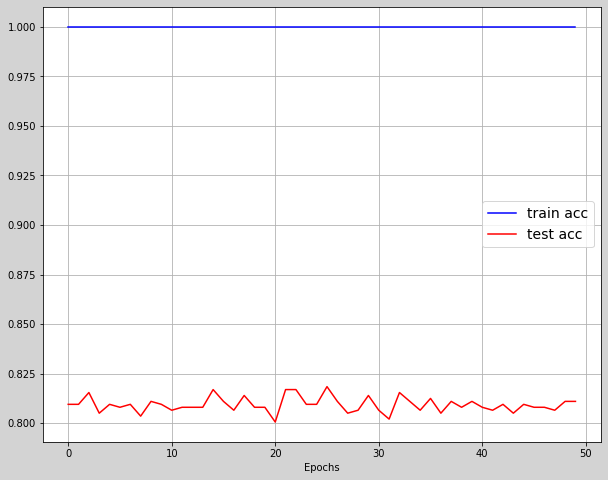

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('lightgray')
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['train acc', 'test acc'], fontsize=14)

plt.xlabel('Epochs')
plt.grid(b=True)

In [ ]:
print(.shape)

(4672, 224, 224, 3)
